In [ ]:
## load the respective datasets for answering the business questions below or you can download them from the processed data in the folder menu

# ANSWERING BUSINESS QUESTIONS

BUSINESS QUESTIONS
1.	Which products/content are most frequently interacted with by users?
2.	Which user segments have similar purchase/viewing behaviors?
3.	What products/content have high engagement but low recommendation exposure?
4.	How do seasonal trends affect product/content interactions?
5.  What time of the day does purchase activity increases?
6.  What are the most frequent item id predicted?
7.  What is the percentage of visitors who made purchase?
8.  What are the total transactions over time?

Top 10 Most Frequently Interacted Items:


,itemid,interaction_count
0,187946,3332
1,5411,2186
2,370653,1705
3,96924,1577
4,298009,1542
5,219512,1457
6,461686,1419
7,335975,1264
8,384302,1225
9,441668,1212


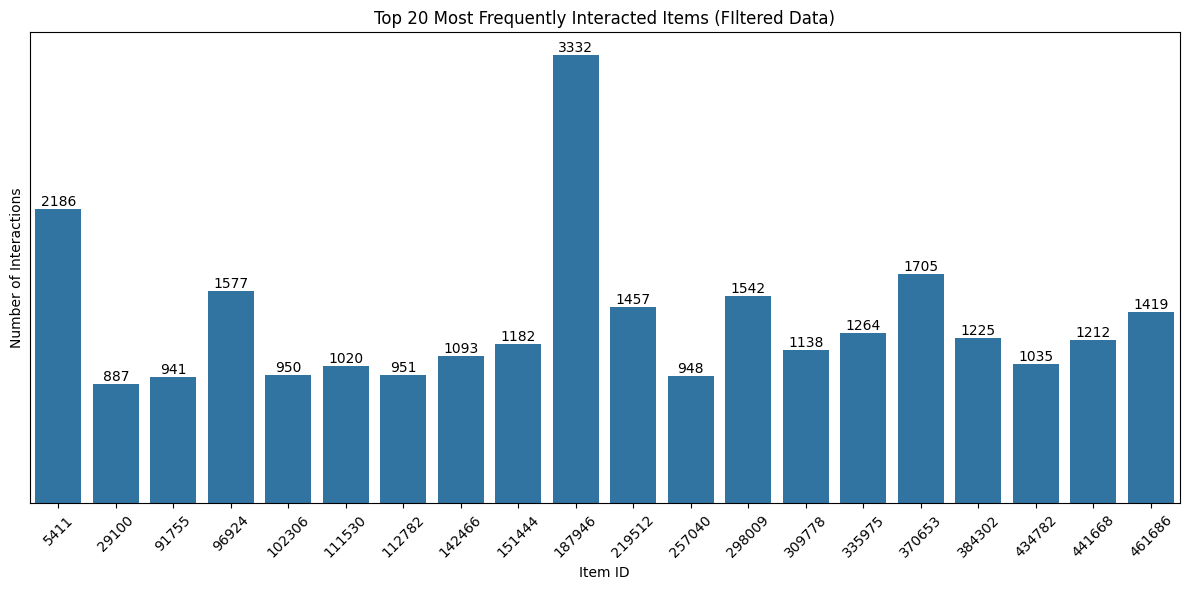

In [ ]:
# which products/content are most frequently interacted with by users?
item_interactions = events_df_filtered['itemid'].value_counts().reset_index()
item_interactions.columns = ['itemid', 'interaction_count']

# Display the top 10 most frequently interacted items
print("Top 10 Most Frequently Interacted Items:")
display(item_interactions.head(10))

# Visualize the top 20 most frequently interacted items
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='itemid', y='interaction_count', data=item_interactions.head(20))
plt.title('Top 20 Most Frequently Interacted Items (FIltered Data)')
plt.xlabel('Item ID')
plt.ylabel('Number of Interactions')
plt.xticks(rotation=45)
ax.set_yticks([]) # Remove y-tick marks and labels

# Add data labels to the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f') # Format as rounded integers

plt.tight_layout()
plt.show()

## User Segmentation

### Subtask:
Analyze user behavior (purchase and viewing history) to identify user segments with similar patterns.

**Reasoning**:
Cluster users based on their interaction features (`num_events`, `unique_events`, `time_spent`, etc.) using K-Means clustering to identify user segments.

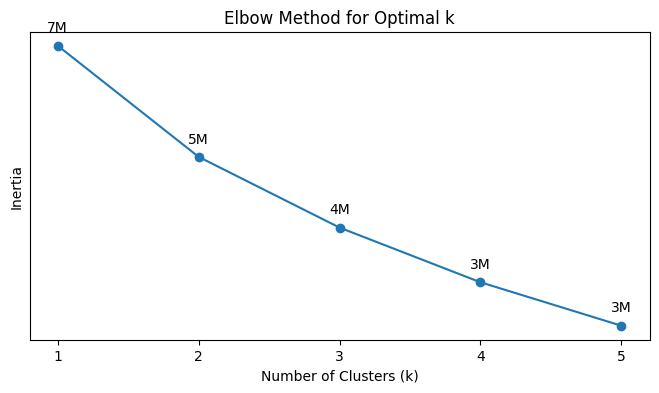


First few rows of user_features with cluster labels:


,visitorid,num_events,unique_events,time_spent,avg_time_between_events,max_time_between_events,num_items_viewed,num_adds_to_cart,num_transactions,anomaly_label,cluster_label
0,0,2,1,-170.152,-85.07600,0.00,2,0,0,1,0
1,1,1,1,0.000,0.00000,0.00,1,0,0,1,0
2,2,4,1,-975.455,-243.86375,455.13,3,0,0,1,0
3,3,1,1,0.000,0.00000,0.00,1,0,0,1,0
4,5,1,1,0.000,0.00000,0.00,1,0,0,1,0



Cluster Analysis:


,visitorid,num_events,unique_events,time_spent,avg_time_between_events,max_time_between_events,num_items_viewed,num_adds_to_cart,num_transactions,anomaly_label
cluster_label,,,,,,,,,,
0,703770.411455,1.516163,1.025322,-4.125999e+04,-1.599166e+04,4.323327e+04,1.294214,0.031739,0.008942,0.868821
1,604990.640000,1074.280000,2.920000,8.833211e+05,7.906946e+02,3.999804e+06,699.240000,86.160000,69.640000,-1.000000
2,695179.422077,9.243966,1.155639,3.522079e+06,1.381584e+06,5.349453e+06,6.614752,0.393987,0.185601,-1.000000


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Select features for clustering from the user_features DataFrame
user_features_for_model = user_features[['num_events', 'unique_events', 'time_spent',
                                         'avg_time_between_events', 'max_time_between_events',
                                         'num_items_viewed', 'num_adds_to_cart', 'num_transactions']].copy()

# Handle potential infinite values which can arise from time difference calculations
user_features_for_model.replace([float('inf'), float('-inf')], float('nan'), inplace=True)

# Fill remaining missing values with 0 or a suitable imputation strategy
# For simplicity, we will fill with 0. Consider other strategies if appropriate.
user_features_for_model.fillna(0, inplace=True)


# Standardize the features
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features_for_model)

# Determine the optimal number of clusters using the elbow method (optional but recommended)
# This can be computationally intensive, so we'll limit the range of k
inertia = []
k_range = range(1, 6) # Limiting to a small range for demonstration

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(user_features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow method graph
plt.figure(figsize=(8, 4))
ax = plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.yticks([]) # Remove y-tick marks and labels

# Add data labels to each point with formatted values
for i, txt in enumerate(inertia):
    if txt >= 1_000_000:
        label = f'{txt/1_000_000:.0f}M'
    elif txt >= 1_000:
        label = f'{txt/1_000:.0f}K'
    else:
        label = f'{txt:.0f}'
    plt.annotate(label, (k_range[i], inertia[i]), textcoords="offset points", xytext=(0,10), ha='center')


plt.show()

# Based on the elbow method (or a predefined number), choose the number of clusters
# Let's assume we choose 3 clusters for demonstration purposes.
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
user_features['cluster_label'] = kmeans.fit_predict(user_features_scaled)

# Display the first few rows with cluster labels
print("\nFirst few rows of user_features with cluster labels:")
display(user_features.head())

# Analyze the characteristics of each cluster
print("\nCluster Analysis:")
display(user_features.groupby('cluster_label').mean())

Based on the cluster analysis, we identified three segments:

**Cluster 0**: Less engaged users with low interaction counts.

**Cluster 1**: Highly engaged users with significantly higher interaction and purchase frequency.

**Cluster 2**: Moderately engaged users with interaction levels between Cluster 0 and Cluster 1.

## Identify High Engagement Items

### Subtask:
Identify products/content that have high engagement based on user interactions.

**Reasoning**:
Analyze the `events_df_sampled` DataFrame to count the occurrences of 'view', 'addtocart', and 'transaction' events for each item to determine engagement levels.

First few rows of item_engagement:


,num_addtocart_events,num_transaction_events,num_view_events,total_interactions
itemid,,,,
3,0,0,2,2
4,0,0,3,3
6,0,0,23,23
9,0,0,2,2
15,0,0,7,7



Top 10 High Engagement Items:


,num_addtocart_events,num_transaction_events,num_view_events,total_interactions
itemid,,,,
187946,0,0,3332,3332
5411,3,0,2183,2186
370653,0,0,1705,1705
96924,0,0,1577,1577
298009,0,0,1542,1542
219512,16,1,1440,1457
461686,45,20,1354,1419
335975,0,0,1264,1264
384302,18,2,1205,1225


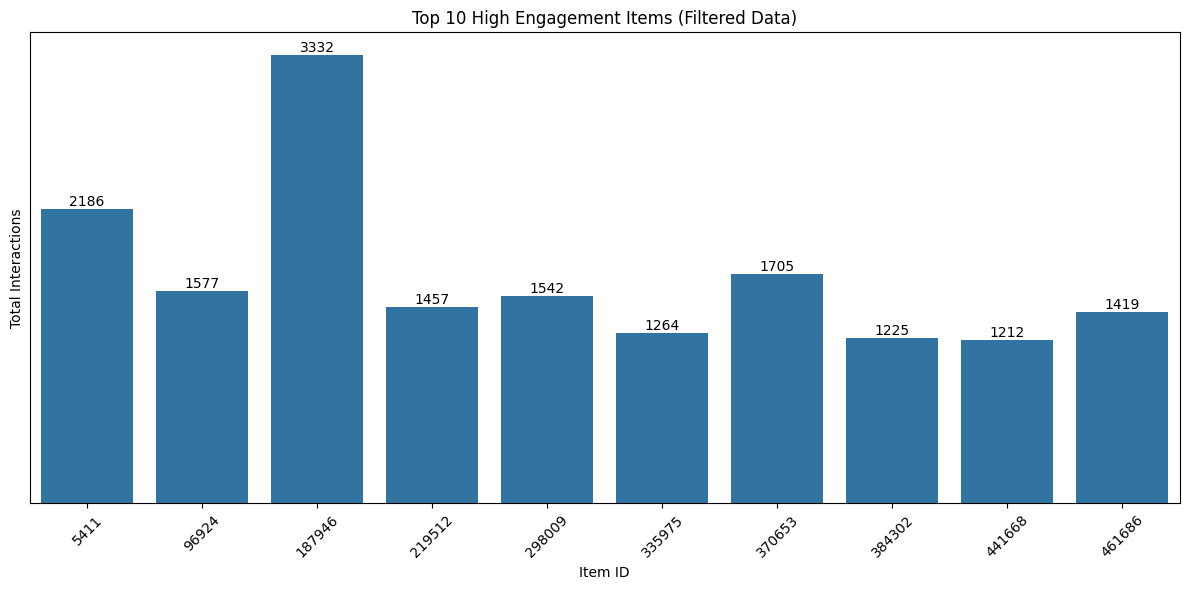


Top 10 Items with High Add-to-Cart Engagement:


,num_addtocart_events,num_transaction_events,num_view_events,total_interactions
itemid,,,,
461686,45,20,1354,1419
320130,43,8,834,885
409804,39,5,289,333
312728,35,7,433,475
257040,31,9,908,948
279457,28,2,312,342
441852,28,5,606,639
29196,28,7,495,530
316753,26,2,447,475


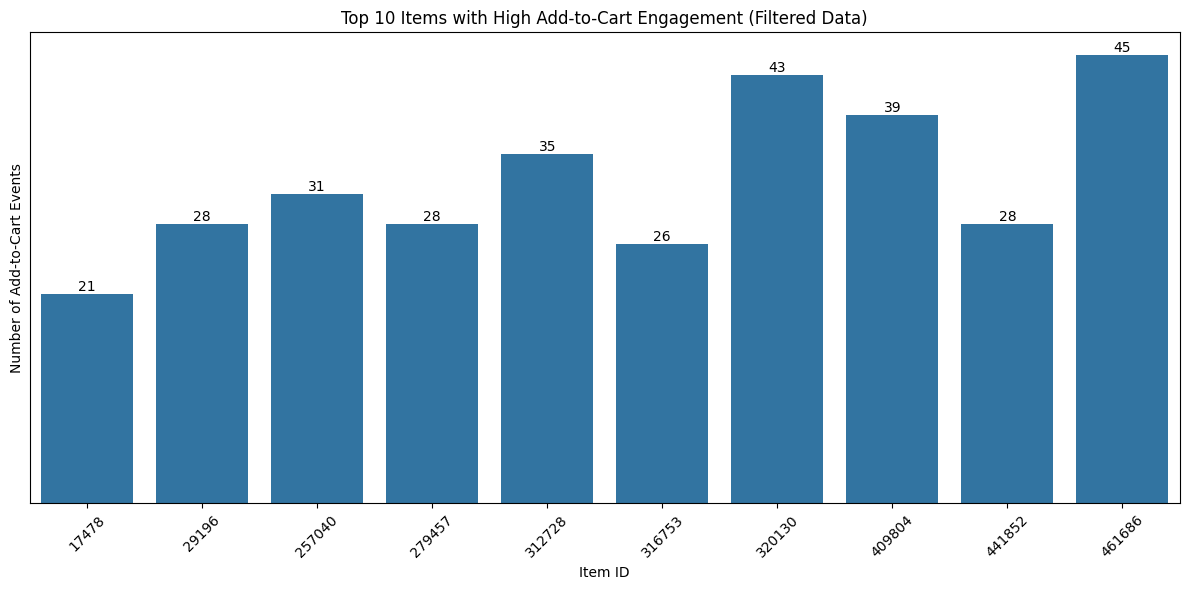

In [ ]:
# Calculate engagement metrics for each item using the sampled data
item_engagement = events_df_filtered.groupby('itemid')['event'].value_counts().unstack(fill_value=0)

# Rename columns for clarity
item_engagement.columns = [f'num_{event}_events' for event in item_engagement.columns]

# Calculate total interactions for each item
item_engagement['total_interactions'] = item_engagement.sum(axis=1)

# Display the first few rows of the item engagement DataFrame
print("First few rows of item_engagement:")
display(item_engagement.head())

# Identify items with high total engagement (e.g., top 100)
high_engagement_items = item_engagement.sort_values(by='total_interactions', ascending=False)

print("\nTop 10 High Engagement Items:")
display(high_engagement_items.head(10))

# Plot the top 10 High Engagement Items
plt.figure(figsize=(12, 6))
ax_high_engagement = sns.barplot(x=high_engagement_items.head(10).index, y=high_engagement_items.head(10)['total_interactions'])
plt.title('Top 10 High Engagement Items (Filtered Data)')
plt.xlabel('Item ID')
plt.ylabel('Total Interactions')
plt.xticks(rotation=45)
ax_high_engagement.set_yticks([]) # Remove y-tick marks and labels

# Add data labels to the bars
for container in ax_high_engagement.containers:
    ax_high_engagement.bar_label(container, fmt='%.0f') # Format as rounded integers

plt.tight_layout()
plt.show()


# We can also look at items with high engagement for specific event types, e.g., 'addtocart'
print("\nTop 10 Items with High Add-to-Cart Engagement:")
display(item_engagement.sort_values(by='num_addtocart_events', ascending=False).head(10))

# Plot the top 10 Items with High Add-to-Cart Engagement
plt.figure(figsize=(12, 6))
ax_high_addtocart = sns.barplot(x=item_engagement.sort_values(by='num_addtocart_events', ascending=False).head(10).index,
                                 y=item_engagement.sort_values(by='num_addtocart_events', ascending=False).head(10)['num_addtocart_events'])
plt.title('Top 10 Items with High Add-to-Cart Engagement (Filtered Data)')
plt.xlabel('Item ID')
plt.ylabel('Number of Add-to-Cart Events')
plt.xticks(rotation=45)
ax_high_addtocart.set_yticks([]) # Remove y-tick marks and labels

# Add data labels to the bars
for container in ax_high_addtocart.containers:
    ax_high_addtocart.bar_label(container, fmt='%.0f') # Format as rounded integers

plt.tight_layout()
plt.show()

## Analyze Seasonal and Hourly Trends

### Subtask:
Analyze the timestamps in the `events` data to identify seasonal and hourly patterns in user interactions.

**Reasoning**:
Extract hour of day, day of week, and month from the timestamps in the `events_df_sampled` DataFrame and visualize the distribution of events across these time periods.

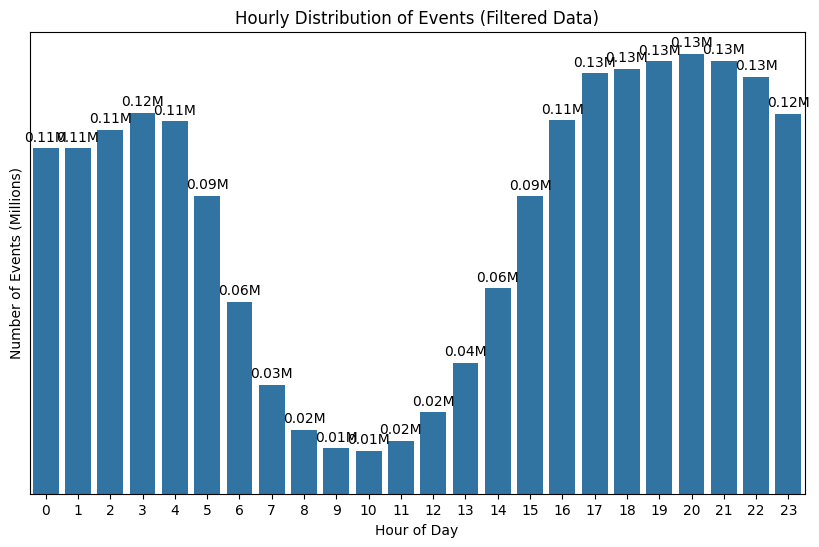

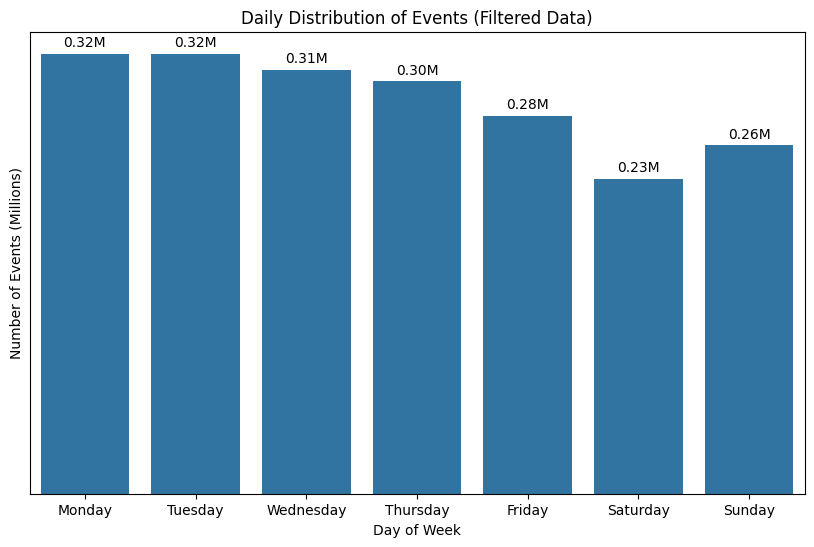

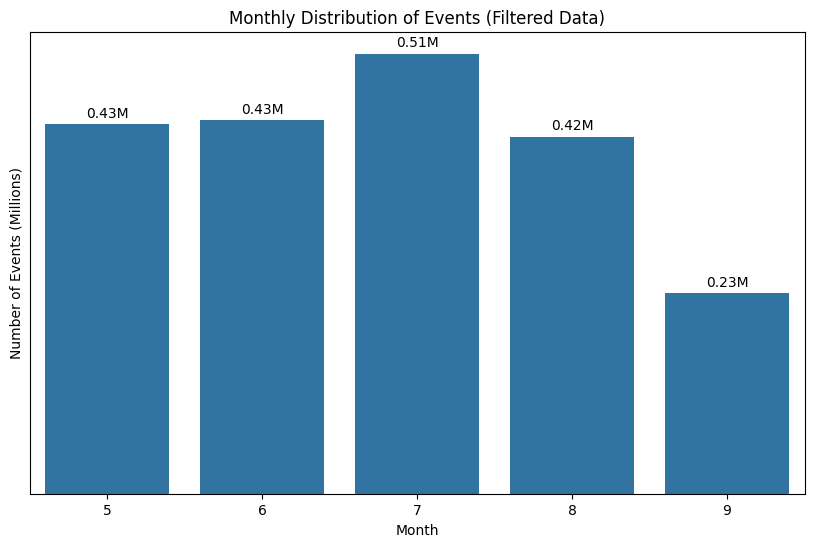

In [ ]:
# Extract time-based features from the timestamp (using the sampled data)
events_df_filtered.loc[:, 'hour'] = events_df_filtered['timestamp'].dt.hour
events_df_filtered.loc[:, 'dayofweek'] = events_df_filtered['timestamp'].dt.dayofweek # Monday=0, Sunday=6
events_df_filtered.loc[:, 'month'] = events_df_filtered['timestamp'].dt.month

# Analyze hourly trends
hourly_trends = events_df_filtered['hour'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
ax_hourly = sns.barplot(x=hourly_trends.index, y=hourly_trends.values / 1_000_000) # Convert to millions
plt.title('Hourly Distribution of Events (Filtered Data)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Events (Millions)') # Update y-axis label
ax_hourly.set_yticks([]) # Remove y-tick marks and labels
for container in ax_hourly.containers:
    ax_hourly.bar_label(container, fmt='%.2fM', padding=3) # Format as .2fM
plt.show()

# Analyze daily trends (day of the week)
daily_trends = events_df_filtered['dayofweek'].value_counts().sort_index()
# Map dayofweek to names for better readability
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(10, 6))
ax_daily = sns.barplot(x=[day_names[i] for i in daily_trends.index], y=daily_trends.values / 1_000_000) # Convert to millions
plt.title('Daily Distribution of Events (Filtered Data)')
plt.xlabel('Day of Week')
plt.ylabel('Number of Events (Millions)') # Update y-axis label
ax_daily.set_yticks([]) # Remove y-tick marks and labels
for container in ax_daily.containers:
    ax_daily.bar_label(container, fmt='%.2fM', padding=3) # Format as .2fM
plt.show()

# Analyze monthly trends
monthly_trends = events_df_filtered['month'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
ax_monthly = sns.barplot(x=monthly_trends.index, y=monthly_trends.values / 1_000_000) # Convert to millions
plt.title('Monthly Distribution of Events (Filtered Data)')
plt.xlabel('Month')
plt.ylabel('Number of Events (Millions)') # Update y-axis label
ax_monthly.set_yticks([]) # Remove y-tick marks and labels
for container in ax_monthly.containers:
    ax_monthly.bar_label(container, fmt='%.2fM', padding=3) # Format as .2fM
plt.show()

Most Frequent Predicted Item IDs:


,itemid,count
0,320130,241
1,29196,207
2,279457,172
3,48030,146
4,46156,141
5,441852,138
6,257040,134
7,445351,129
8,56782,125
9,316753,117


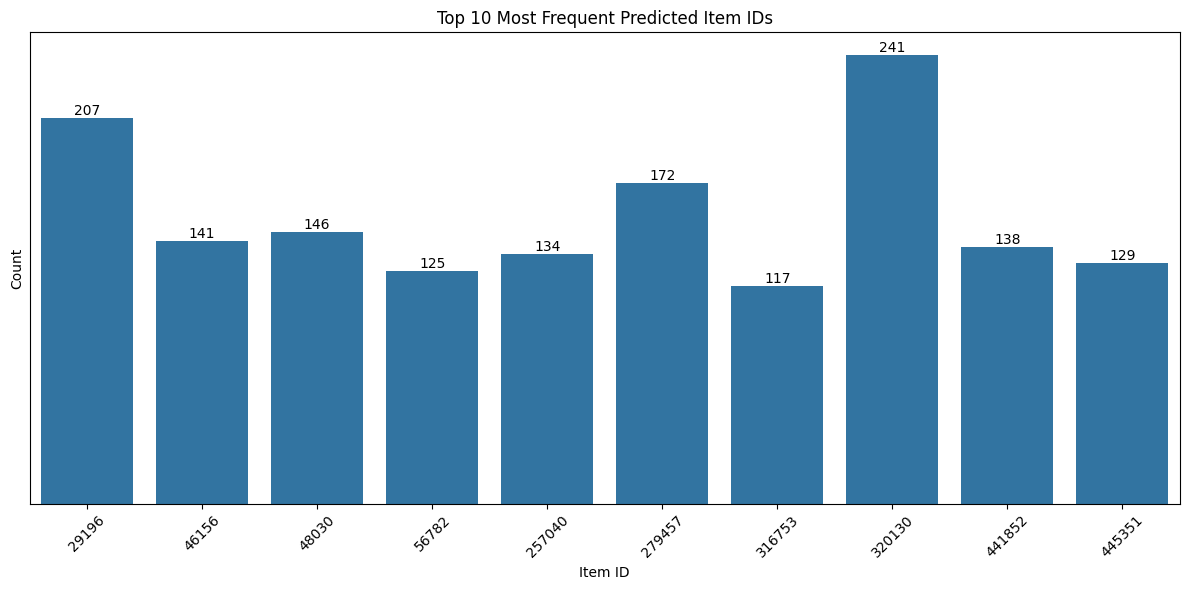

In [ ]:
# What are the most frequent item id predicted?

# Count the occurrences of each itemid in the X_test DataFrame
predicted_itemid_counts = X_test['itemid'].value_counts().reset_index()
predicted_itemid_counts.columns = ['itemid', 'count']

# Display the most frequent itemids
print("Most Frequent Predicted Item IDs:")
display(predicted_itemid_counts.head(10)) # Display top 10

# Visualize the top 10 most frequent predicted itemids
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='itemid', y='count', data=predicted_itemid_counts.head(10))
plt.title('Top 10 Most Frequent Predicted Item IDs')
plt.xlabel('Item ID')
plt.ylabel('Count')
plt.xticks(rotation=45)
ax.set_yticks([]) # Remove y-tick marks and labels

# Add data labels to the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f') # Format as rounded integers

plt.tight_layout()
plt.show()

Number of unique visitors who made a purchase: 2761

First 10 visitor IDs who made a purchase:


array([ 186,  419,  964, 2807, 3251, 3581, 4241, 4694, 4899, 6265])


Total number of unique visitors: 1343344

Percentage of visitors who made a purchase: 0.21%


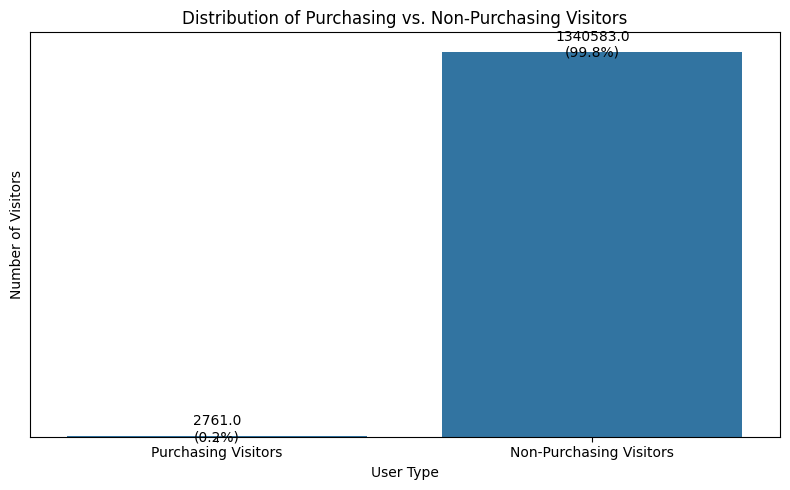

In [ ]:
# What is the percentage of visitors who made purchase?
# Identify visitors who made a purchase

# Filter the events DataFrame for 'transaction' filtered events
purchase_events = events_df_filtered[events_df_filtered['event'] == 'transaction']

# Get the unique visitor IDs from the purchase events
purchasing_visitors = purchase_events['visitorid'].unique()

print("Number of unique visitors who made a purchase:", len(purchasing_visitors))
print("\nFirst 10 visitor IDs who made a purchase:")
display(purchasing_visitors[:10])

# Calculate the total number of unique visitors in the filtered events DataFrame
total_unique_visitors = events_df_filtered['visitorid'].nunique()

print(f"\nTotal number of unique visitors: {total_unique_visitors}")

# Calculate the percentage of visitors who made a purchase
percentage_purchasing_visitors = (len(purchasing_visitors) / total_unique_visitors) * 100

print(f"\nPercentage of visitors who made a purchase: {percentage_purchasing_visitors:.2f}%")

# Visualize the percentage of visitors who made a purchase
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame for visualization
purchase_counts = pd.DataFrame({
    'User Type': ['Purchasing Visitors', 'Non-Purchasing Visitors'],
    'Count': [len(purchasing_visitors), total_unique_visitors - len(purchasing_visitors)]
})

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='User Type', y='Count', data=purchase_counts)
plt.title('Distribution of Purchasing vs. Non-Purchasing Visitors')
plt.xlabel('User Type')
plt.ylabel('Number of Visitors')
ax.set_yticks([]) # Remove y-tick marks and labels

# Add data labels (counts and percentages)
total = purchase_counts['Count'].sum()
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        percentage = f'{100 * height / total:.1f}%'
        ax.annotate(f'{height}\n({percentage})', (patch.get_x() + patch.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

First few rows of daily transactions over time:


,timestamp,transaction_count
0,2015-05-03,8
1,2015-05-04,29
2,2015-05-05,37
3,2015-05-06,36
4,2015-05-07,25


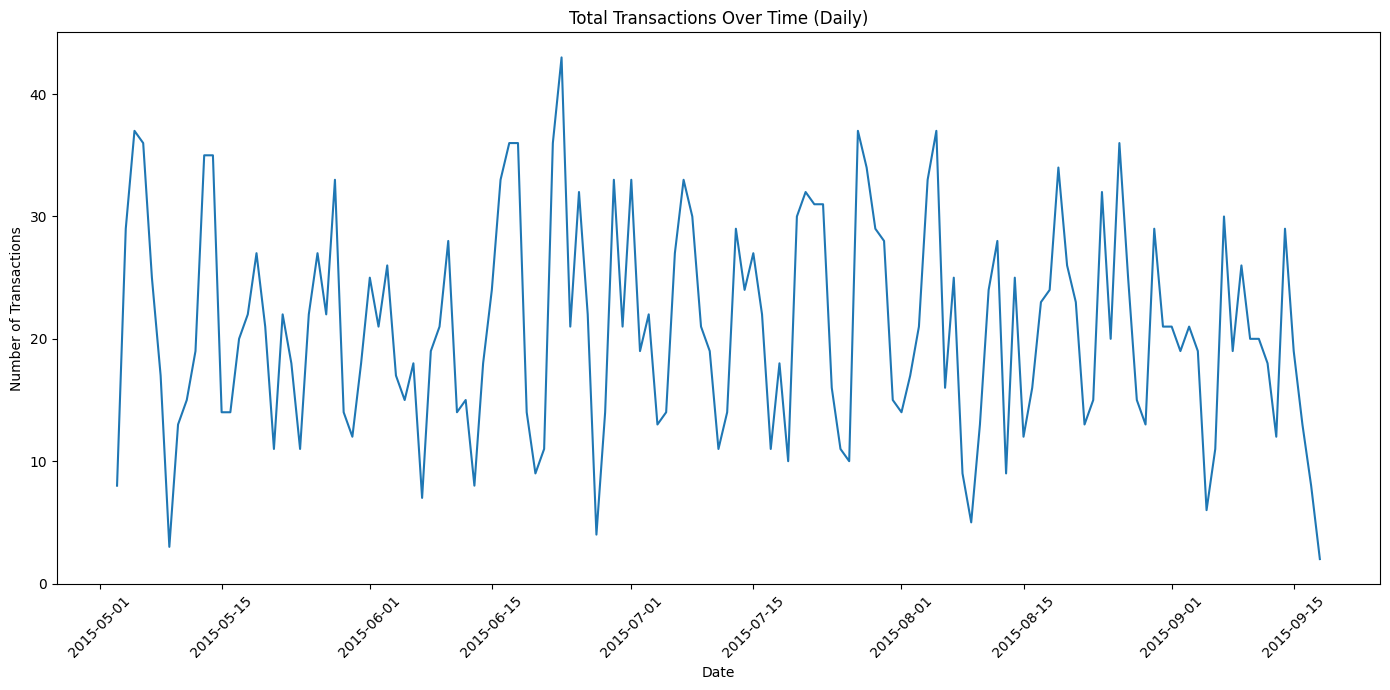

In [ ]:
# What are the total transactions over time?

# Filter the events DataFrame for 'transaction' events
transaction_events = events_df_filtered[events_df_filtered['event'] == 'transaction'].copy()

# Set the 'timestamp' column as the index and resample to get daily transaction counts
# 'D' stands for daily frequency. You could use 'W' for weekly, 'M' for monthly, etc.
daily_transactions = transaction_events.set_index('timestamp').resample('D').size().reset_index(name='transaction_count')

# Display the first few rows of the daily transactions DataFrame
print("First few rows of daily transactions over time:")
display(daily_transactions.head())

# Visualize the total transactions over time
plt.figure(figsize=(14, 7))
sns.lineplot(x='timestamp', y='transaction_count', data=daily_transactions)
plt.title('Total Transactions Over Time (Daily)')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()